In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_io as tfio
import os 
print(tf.__version__)
print(tfio.__version__)
import matplotlib.pyplot as plt

2.10.0
0.27.0


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
CAPUCHIN = "Gunshots/106955-6-0-0.wav"
NOT_CAPUCHIN = 'Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-4.wav'

JUST FOR VISUALIZATION PURPOSE

In [4]:
def get_audio(filepath):
    file_contents = tf.io.read_file(filepath)
    wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    wav = tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)
    wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

In [5]:
file_contents = tf.io.read_file(CAPUCHIN)
wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
wav
sample_rate
wav = tfio.audio.resample(wav,rate_in=44100,rate_out=16000)
wav

<tf.Tensor: shape=(18400, 1), dtype=float32, numpy=
array([[-6.6636971e-09],
       [ 1.9112765e-08],
       [ 4.2049315e-09],
       ...,
       [ 3.9012648e-02],
       [ 4.3579541e-02],
       [ 4.1023836e-02]], dtype=float32)>

In [6]:
wav = get_audio(CAPUCHIN)
nwave = get_audio(NOT_CAPUCHIN)

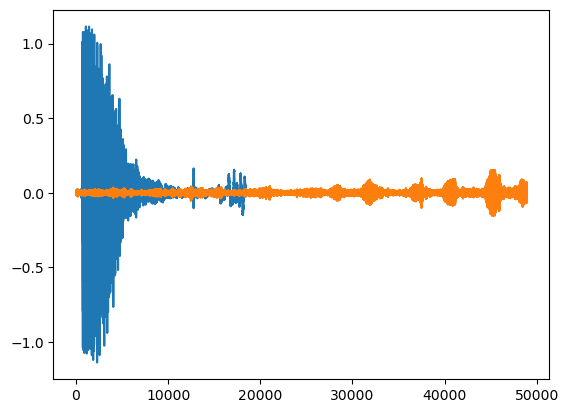

In [7]:
plt.plot(wav)
plt.plot(nwave)
plt.show()

In [8]:
BIRD = "Parsed_Capuchinbird_Clips"
NO_SOUND = "Parsed_Not_Capuchinbird_Clips"
LION = "Pure_Lion"
GUN = "gunshots_version2"

In [9]:
pos1 = tf.data.Dataset.list_files(BIRD+"/*.wav")
pos2 = tf.data.Dataset.list_files(LION+"/*.wav")
pos3 = tf.data.Dataset.list_files(GUN+"/*.wav")
neg = tf.data.Dataset.list_files(NO_SOUND+"/*.wav")

cap = tf.ones(len(pos1),tf.int32)
cap = tf.keras.utils.to_categorical(cap,4)

no_cap = tf.zeros(len(neg),tf.int32)
no_cap = tf.keras.utils.to_categorical(no_cap,4)

lion = np.full(25,2,dtype=int)
lion = tf.convert_to_tensor(lion)
lion = tf.keras.utils.to_categorical(lion,4)
gun = np.full(374,3,dtype=int)
gun = tf.convert_to_tensor(gun)
gun = tf.keras.utils.to_categorical(gun,4)

In [10]:
class_list = ["ambient","capuchin","lion","gun"]

In [11]:
# pos1 = tf.data.Dataset.list_files(YES+"/*.wav")
# pos2 = tf.data.Dataset.list_files(YES[1]+"/*.wav")
# pos3 = tf.data.Dataset.list_files(YES[2]+"/*.wav")
# neg = tf.data.Dataset.list_files(NO+"/*.wav")
pos1.as_numpy_iterator().next()
pos2.as_numpy_iterator().next()
pos3.as_numpy_iterator().next()
# pos3.as_numpy_iterator().next()
positives = tf.data.Dataset.zip((pos1,tf.data.Dataset.from_tensor_slices(cap)))
positives2 = tf.data.Dataset.zip((pos2,tf.data.Dataset.from_tensor_slices(lion)))
positives3 = tf.data.Dataset.zip((pos3,tf.data.Dataset.from_tensor_slices(gun)))
# positives3 = tf.data.Dataset.zip((pos3,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos3)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(no_cap)))
data1=positives.concatenate(positives2)
data2 = data1.concatenate(positives3)
data3=data2.concatenate(negatives)
data3.shuffle(1000).as_numpy_iterator().next()
len(data3)

1210

## Finding the average length of a bird call

In [12]:
lengths = []
for file in os.listdir("Parsed_Capuchinbird_Clips"):
    tensor_wave = get_audio(os.path.join("Parsed_Capuchinbird_Clips",file))
    lengths.append(len(tensor_wave))

In [13]:
lengths
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
def preprocess(file_path,label):
    wav = get_audio(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)#preprocessing the spectrogram
    spectrogram = tf.abs(spectrogram)#remove the negatives
    spectrogram = tf.expand_dims(spectrogram,axis=2)#adding a channel dim for the cnn
    return spectrogram,label

In [15]:
##### MODIFIED CODE ###
def preprocess_lstm(file_path,label):
    wav = get_audio(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)#preprocessing the spectrogram
    spectrogram = tf.abs(spectrogram)#remove the negatives
    # spectrogram = tf.expand_dims(spectrogram,axis=2)#adding a channel dim for the cnn
    return spectrogram,label

In [16]:
filepath,label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectogram,label = preprocess_lstm(filepath,label)
spectogram  
print(spectogram.shape)
print(label)

(1491, 257)
[1. 0. 0. 0.]


(1491, 257, 1)
[0. 0. 0. 1.]


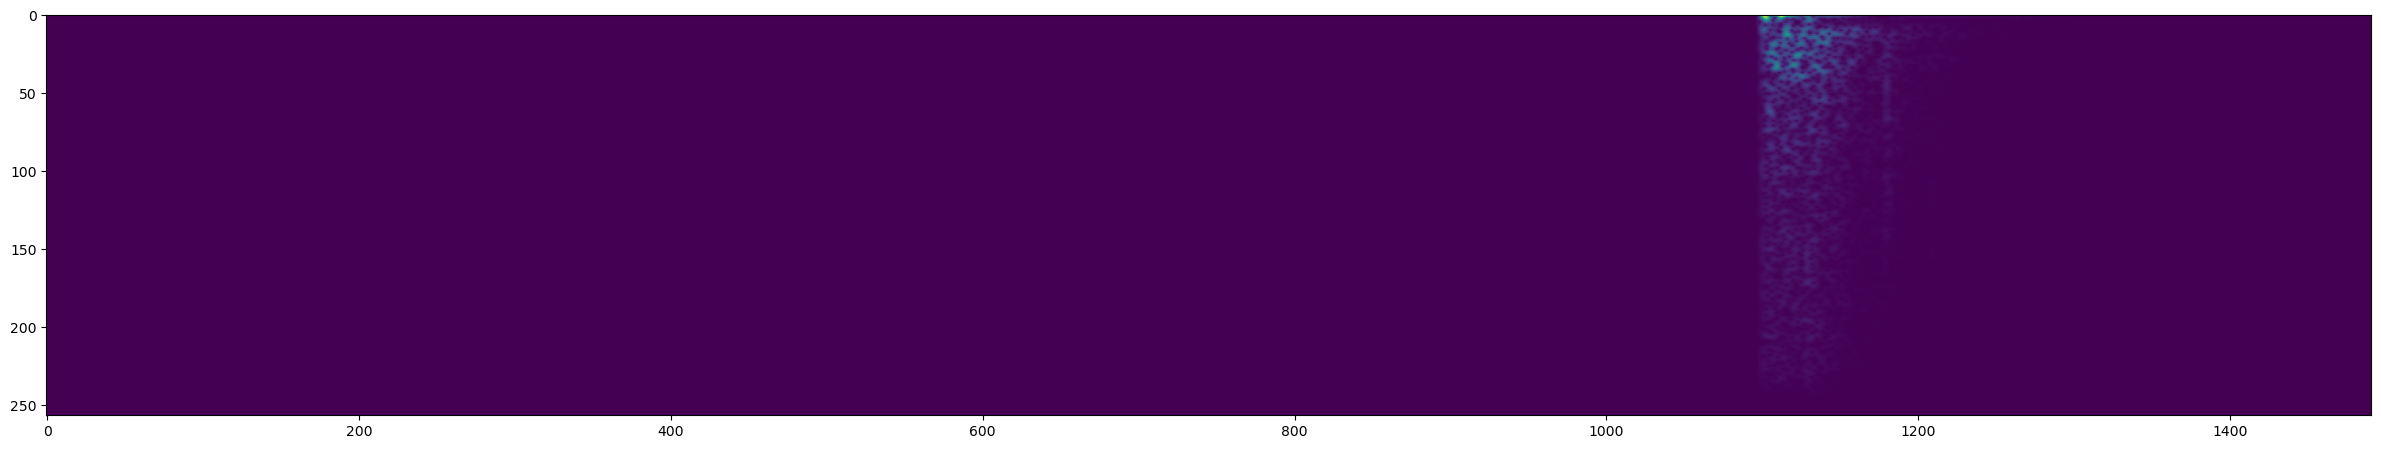

In [17]:
filepath,label = positives3.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectogram,label = preprocess(filepath,label)
spectogram  
print(spectogram.shape)
print(label)
plt.figure(figsize=(30,30))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

# Creating Data Pipeline

In [18]:
data3.shuffle(1000).as_numpy_iterator().next()

(b'gunshots_version2\\52284-6-0-0_converted.wav',
 array([0., 0., 0., 1.], dtype=float32))

In [19]:
# data3 = data3.map(preprocess)
# data3 = data3.cache()
# data3 = data3.shuffle(buffer_size=1000)
# data3 = data3.batch(16)
# data3 = data3.prefetch(8)


In [20]:
# print(0.7*len(data3))
# print(len(data3))
# train_size = data3.take(36)
# test_size = data3.skip(36).take(15)

In [21]:
# samples,labels = train_size.as_numpy_iterator().next()
# print(samples.shape,labels)


## CHANGES

In [22]:
data3 = data3.map(preprocess_lstm)
data3 = data3.cache()
data3 = data3.shuffle(buffer_size=1000)
data3 = data3.batch(16)
data3 = data3.prefetch(8)

In [23]:
print(0.7*len(data3))
print(len(data3))

53.199999999999996
76


In [24]:
lstm_train_size = data3.take(54)
lstm_test_size = data3.skip(54).take(22)

In [25]:
sample,label = lstm_train_size.as_numpy_iterator().next()
print(sample.shape)
print(label.shape)

(16, 1491, 257)
(16, 4)


In [26]:
lstm_train_size.as_numpy_iterator().next()[0].shape[1]

1491

# Building CNN

In [27]:
from sklearn.model_selection import train_test_split
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,Dropout,LSTM,TimeDistributed,BatchNormalization
from keras.api._v2.keras.optimizers import Adam

In [28]:
def load_data(data_iter):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    # with open(data_path, "r") as fp:
    #     data = json.load(fp)
    X = []
    y=[]
    for item in data_iter.as_numpy_iterator():
        X.append(item[0])
        y.append(item[1])
        # break
    X = np.array(X)
    y = np.array(y)
    return X,y

In [29]:
def prepare_datasets(test_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(data3)
    # print(X)
    # print("--------------")
    # print(y)
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    y_train = tf.keras.utils.to_categorical(y_train,2)
    y_test = tf.keras.utils.to_categorical(y_test,2)
    # X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train,X_test, y_train, y_test

def build_model(input_shape):
    """Generates RNN model
    :param input_shape (tuple): Shape of input set
    :return model: RNN model
    """

    # build network topology
    model = Sequential()
    model.add(LSTM(units=128,input_shape=input_shape,return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=128,return_sequences=True)) 
    model.add(LSTM(units=128,return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(64,activation="relu")))
    model.add(TimeDistributed(Dense(32,activation="relu")))
    model.add(TimeDistributed(Dense(16,activation="relu")))
    model.add(TimeDistributed(Dense(8,activation="relu")))
    model.add(Flatten())
    # output layer
    model.add(Dense(4, activation='softmax'))

    return model

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [30]:
s,l = lstm_train_size.as_numpy_iterator().next()
st,lt = lstm_test_size.as_numpy_iterator().next()
print(s.shape)
print(l.shape)
print(st.shape)
print(lt.shape)

(16, 1491, 257)
(16, 4)
(16, 1491, 257)
(16, 4)


(1491, 257)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1491, 128)         197632    
                                                                 
 batch_normalization (BatchN  (None, 1491, 128)        512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 1491, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 1491, 128)         131584    
                                                                 
 dropout (Dropout)           (None, 1491, 128)         0         
                                                                 
 time_distributed (TimeDistr  (None, 1491, 64)         8256      
 ibuted)                                    

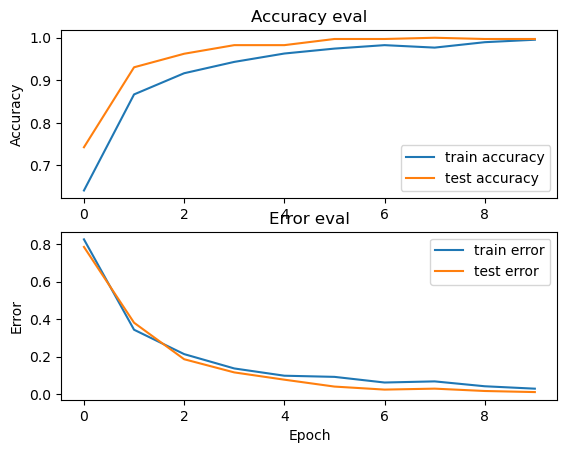

In [31]:
# X_train, X_test, y_train, y_test = prepare_datasets(0.25) #25% testing , 20% of 75 for val

# create network
input_shape = (1491, 257)
print(input_shape)
# y_train = tf.keras.utils.to_categorical(y_train,3)
# y_test = tf.keras.utils.to_categorical(y_test,3)
# # y_test = np.expand_dims(y_test,axis=-1)
# print(y_train.shape)
# print(X_test.shape)
model = build_model(input_shape)

# compile model
optimiser = Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

model.summary()

# train model
history = model.fit(lstm_train_size,validation_data=lstm_test_size, batch_size=8, epochs=10)

# plot accuracy/error for training and validation
plot_history(history)



In [32]:
# # evaluate model on test set
# test_loss, test_precision,test_recall,test_acc = model.evaluate(X_test, y_test, verbose=2)
# print('\nTest accuracy:', test_acc)



In [33]:
# print(y_test)

In [34]:
# # pick a sample to predict from the test set
# X_to_predict = X_test[3]
# y_to_predict = y_test[3]

# for item in range(len(X_test)):
#     predict(model,X_test[item],y_test[item])
    
# predict(model, X_to_predict, y_to_predict)

In [35]:
np.set_printoptions(suppress=True)

In [36]:
X_test,y_test = lstm_test_size.as_numpy_iterator().next()
print(X_test)
print(y_test)
# y_test.shape

[[[0.00086943 0.00143392 0.00255874 ... 0.00000934 0.00000145 0.00000063]
  [0.00014628 0.00151149 0.00228788 ... 0.00001605 0.00000428 0.00000592]
  [0.00067999 0.00163689 0.00176214 ... 0.00001043 0.0000131  0.00000789]
  ...
  [0.00491332 0.01775539 0.03390766 ... 0.00000824 0.00000685 0.00000174]
  [0.00840363 0.01778747 0.03718053 ... 0.00001065 0.00000342 0.00000116]
  [0.0048694  0.01905393 0.03981606 ... 0.00001209 0.00000442 0.00000405]]

 [[0.01664603 0.01665161 0.02266369 ... 0.00093    0.00020348 0.00007975]
  [0.0065476  0.01654124 0.03408215 ... 0.00071338 0.00023625 0.0001705 ]
  [0.00108224 0.01579961 0.03663317 ... 0.00055082 0.00029611 0.00007415]
  ...
  [0.01723953 0.01376    0.04051429 ... 0.00041435 0.00030033 0.00009829]
  [0.00875795 0.00707416 0.03169465 ... 0.00044354 0.00036336 0.00006646]
  [0.0021043  0.00258129 0.02501312 ... 0.00058938 0.00036237 0.00006714]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [37]:
X_test.shape

(16, 1491, 257)

In [38]:
preds = model.predict(X_test)


1/1 [==============================] - 5s 5s/step


In [39]:
preds


array([[1.        , 0.00000002, 0.        , 0.        ],
       [0.9999919 , 0.00000785, 0.00000026, 0.        ],
       [0.00058176, 0.00091572, 0.02683369, 0.9716689 ],
       [0.00000115, 0.00000511, 0.00001767, 0.99997616],
       [0.99869436, 0.00009719, 0.00118344, 0.00002512],
       [0.01558449, 0.00003953, 0.0025853 , 0.98179066],
       [0.00000418, 0.00000081, 0.00005807, 0.99993694],
       [0.99999464, 0.00000523, 0.0000001 , 0.        ],
       [0.99978596, 0.00000016, 0.00021394, 0.00000002],
       [0.00017386, 0.99982613, 0.00000004, 0.        ],
       [0.00000067, 0.9999993 , 0.00000003, 0.        ],
       [0.00000088, 0.99999917, 0.        , 0.        ],
       [0.9999951 , 0.00000485, 0.00000002, 0.        ],
       [0.9992286 , 0.00000475, 0.00075704, 0.00000962],
       [0.00000055, 0.9999994 , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [40]:
res = [class_list[np.argmax(x)] for x in preds]
res

['ambient',
 'ambient',
 'gun',
 'gun',
 'ambient',
 'gun',
 'gun',
 'ambient',
 'ambient',
 'capuchin',
 'capuchin',
 'capuchin',
 'ambient',
 'ambient',
 'capuchin',
 'ambient']

In [41]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [42]:
def load_mp3_16k(filepath):
    res = tfio.audio.AudioIOTensor(filepath)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)   
    wav = tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [43]:
import librosa
sr = librosa.get_samplerate("W_Forest/gun_bird_test.wav")
sr

48000

In [44]:
mp3 = "W_Forest/all_combined.mp3"
wav = load_mp3_16k(mp3)
print(wav)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3222673,), dtype=float32)


In [45]:
def preprocessmp3(sample,index):
    sample = sample[0]
    zero_padding = tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
    wav = tf.concat([zero_padding,sample],0)
    spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)#preprocessing the spectrogram
    spectrogram = tf.abs(spectrogram)#remove the negatives
    # spectrogram = tf.expand_dims(spectrogram,axis=2)#adding a channel dim for the cnn
    return spectrogram


In [53]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices = audio_slices.map(preprocessmp3)
audio_slices=audio_slices.batch(8)

In [54]:
yhat = model.predict(audio_slices)


8/8 [==============================] - 3s 294ms/step


In [55]:
preds = [(class_list[np.argmax(x)],(index+1)*2) for index,x in enumerate(yhat)]
preds

[('ambient', 2),
 ('ambient', 4),
 ('ambient', 6),
 ('ambient', 8),
 ('ambient', 10),
 ('ambient', 12),
 ('ambient', 14),
 ('ambient', 16),
 ('ambient', 18),
 ('ambient', 20),
 ('ambient', 22),
 ('ambient', 24),
 ('ambient', 26),
 ('ambient', 28),
 ('ambient', 30),
 ('ambient', 32),
 ('ambient', 34),
 ('ambient', 36),
 ('ambient', 38),
 ('ambient', 40),
 ('ambient', 42),
 ('ambient', 44),
 ('capuchin', 46),
 ('ambient', 48),
 ('ambient', 50),
 ('ambient', 52),
 ('ambient', 54),
 ('ambient', 56),
 ('ambient', 58),
 ('ambient', 60),
 ('ambient', 62),
 ('ambient', 64),
 ('ambient', 66),
 ('ambient', 68),
 ('ambient', 70),
 ('ambient', 72),
 ('ambient', 74),
 ('ambient', 76),
 ('ambient', 78),
 ('ambient', 80),
 ('ambient', 82),
 ('ambient', 84),
 ('ambient', 86),
 ('ambient', 88),
 ('ambient', 90),
 ('ambient', 92),
 ('capuchin', 94),
 ('ambient', 96),
 ('ambient', 98),
 ('ambient', 100),
 ('ambient', 102),
 ('ambient', 104),
 ('ambient', 106),
 ('ambient', 108),
 ('ambient', 110),
 ('amb

In [69]:
sample = "W_Forest/all_combined.wav"
wav = get_audio(sample)
# audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices = audio_slices.map(preprocessmp3)
audio_slices=audio_slices.batch(8)

In [70]:
yhat = model.predict(audio_slices)
print(yhat)

9/9 [==============================] - 2s 161ms/step
[[0.069343   0.92620385 0.00406794 0.00038523]
 [0.22029775 0.77956283 0.00013827 0.00000123]
 [0.23044598 0.75985205 0.00954955 0.0001524 ]
 [0.38261288 0.591214   0.02442293 0.00175023]
 [0.99316263 0.00501327 0.00130725 0.00051684]
 [0.02259175 0.9645416  0.00263907 0.01022755]
 [0.1297973  0.870105   0.00009577 0.00000185]
 [0.38073653 0.5976845  0.02122523 0.00035379]
 [0.08129209 0.91762406 0.00106867 0.00001522]
 [0.60582143 0.37568024 0.0175709  0.00092743]
 [0.01373019 0.981141   0.00105204 0.00407683]
 [0.53297544 0.46688923 0.00013533 0.        ]
 [0.02124315 0.9705848  0.00558682 0.00258527]
 [0.13173926 0.85971534 0.00841    0.0001354 ]
 [0.21259622 0.785571   0.00181958 0.00001325]
 [0.84288925 0.14970532 0.00734352 0.00006199]
 [0.0012589  0.00017179 0.00023086 0.99833846]
 [0.12464815 0.87045825 0.00480313 0.00009048]
 [0.9843255  0.00430013 0.00545663 0.00591763]
 [0.08214706 0.90702784 0.00355547 0.0072696 ]
 [0.031

In [71]:
preds = [(class_list[np.argmax(x)],(index+1)) for index,x in enumerate(yhat)]
preds

[('capuchin', 1),
 ('capuchin', 2),
 ('capuchin', 3),
 ('capuchin', 4),
 ('ambient', 5),
 ('capuchin', 6),
 ('capuchin', 7),
 ('capuchin', 8),
 ('capuchin', 9),
 ('ambient', 10),
 ('capuchin', 11),
 ('ambient', 12),
 ('capuchin', 13),
 ('capuchin', 14),
 ('capuchin', 15),
 ('ambient', 16),
 ('gun', 17),
 ('capuchin', 18),
 ('ambient', 19),
 ('capuchin', 20),
 ('capuchin', 21),
 ('capuchin', 22),
 ('capuchin', 23),
 ('capuchin', 24),
 ('capuchin', 25),
 ('capuchin', 26),
 ('capuchin', 27),
 ('capuchin', 28),
 ('capuchin', 29),
 ('capuchin', 30),
 ('gun', 31),
 ('capuchin', 32),
 ('ambient', 33),
 ('ambient', 34),
 ('capuchin', 35),
 ('capuchin', 36),
 ('lion', 37),
 ('capuchin', 38),
 ('capuchin', 39),
 ('capuchin', 40),
 ('capuchin', 41),
 ('capuchin', 42),
 ('capuchin', 43),
 ('capuchin', 44),
 ('ambient', 45),
 ('capuchin', 46),
 ('capuchin', 47),
 ('capuchin', 48),
 ('ambient', 49),
 ('capuchin', 50),
 ('capuchin', 51),
 ('capuchin', 52),
 ('capuchin', 53),
 ('capuchin', 54),
 ('cap

In [52]:
# model.save("bird-gun.h5")